In [9]:
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
from kerchunk.combine import concatenate_arrays
from kerchunk.zarr import ZarrToZarr
import kerchunk
import fsspec
import h5py

from ease_grid.ease2_grid import EASE2_grid
import subprocess
import pandas as pd
from dask import delayed, compute
from dask.distributed import Client, as_completed
import numpy as np

import gc
from typing import Tuple, List
import os
from pathlib import Path
os.chdir('/nesi/nobackup/niwa00004/meyerstj/data/SMAP')

### SMAP data guides
- <b>User guide for SMAP L3 SPM_E (9km)</b>: https://nsidc.org/sites/default/files/documents/user-guide/spl3smp_e-v006-userguide.pdf
- <b>Paper doing validation on SMAP, has good explanations</b>: https://www.mdpi.com/2071-1050/15/11/9112
- <b> Summary data table of all SMAP products</b>: https://nsidc.org/data/user-resources/help-center/what-data-subsetting-reformatting-and-reprojection-services-are-available-smap-data
- <b> `wget` how to </b> https://nsidc.org/data/user-resources/help-center/programmatic-data-access-guide
- <b>JPL SMAP summary</b>: https://smap.jpl.nasa.gov/data/
- <b> `SMAP DATA` </b>: https://n5eil01u.ecs.nsidc.org/SMAP/

### Projections
- <b> EASE2Grid projections done in this notebook</b>: https://github.com/nsidc/smap_python_notebooks/blob/main/notebooks/2.0%20Read%20and%20Plot%20SMAP%20data.ipynb 


In [2]:
# Constants =======

# wget command for SMAP
CMD = 'wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --no-check-certificate --auth-no-challenge=on -r --reject "index.html*" -np -e robots=off '

# root directory for SMAP
SMAP_DIRECTORY = "n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006"

# Ony extract these fields.
SMAP_EXTRACT_FIELDS = ['soil_moisture', 'soil_moisture_error', 'soil_moisture_scah', 'soil_moisture_scav', 'soil_moisture_dca_pm', 'soil_moisture_error_pm', 'soil_moisture_scah_pm', 'soil_moisture_scav_pm']

# EASE grid for re-gridding
EASE_GRID = EASE2_grid(9000)

# Functions =========

def add_smap_coords(ds: xr.Dataset, date : pd.Timestamp ) -> xr.Dataset:
    '''
    SMAP data is read in with "phony_dim_x" coords. We have to populate these dimensions with latitude
    and longitude values from ease2_grids, then assign them as coords. It is also helpful to 
    add the time coordinate.
    '''
    ds = ds.rename({'phony_dim_0':'lat', 'phony_dim_1':'lon'})
    lats = EASE_GRID.latdim[2:-2]
    lons = EASE_GRID.londim[2:]
    ds = ds.assign_coords({'lat':lats, 'lon':lons, 'time': pd.to_datetime(date)}).expand_dims('time')

    ds = ds.transpose('time', 'lat', 'lon')

    return ds

def download_smap(date: pd.Timestamp, force: bool = True) -> Tuple[xr.Dataset,str]:
    '''
    Downloads the smap data using a wget command, then opens it as an xarray dataset.
    '''
    
    url, fname, oname = create_smap_fpaths(date)

    if force or not Path(fname).exists():
        cmd = CMD + url
        p = subprocess.Popen(cmd, shell=True)
        p_status = p.wait()
        
    json = SingleHdf5ToZarr(fname).translate()

    ds = xr.merge([open_kerchunk(json, "Soil_Moisture_Retrieval_Data_AM"),open_kerchunk(json, "Soil_Moisture_Retrieval_Data_PM")])
    ds = ds[SMAP_EXTRACT_FIELDS]

    return ds, oname

def open_kerchunk(json : dict, group : str) -> xr.Dataset :
    '''
    opens a json file created by kerchunk as an xarray dataset.
    '''
    return xr.open_dataset(json, engine="kerchunk", chunks = {}, group = group)

def create_smap_fpaths(date : pd.Timestamp) -> Tuple[str,str,str] :
    '''
    Generates 3 path names:
    1. Url of SMAP on the NASA
    2. File name of the .h5 file on disc (this created automatically via wget)
    3. Name of the output zarr file. 
    '''
    date = pd.to_datetime(date)
    datestr_fname = date.strftime('%Y%m%d')
    datestr_dname = date.strftime('%Y.%m.%d')
    
    url = f'https://{SMAP_DIRECTORY}/{datestr_dname}/SMAP_L3_SM_P_E_{datestr_fname}_R19240_001.h5'
    fname = f'{SMAP_DIRECTORY}/{datestr_dname}/SMAP_L3_SM_P_E_{datestr_fname}_R19240_001.h5'
    oname = f'{SMAP_DIRECTORY}/zarr/SMAP_L3_SM_P_E_{datestr_fname}_R19240_001.zarr'

    return url, fname, oname

def extract_smap(date : pd.Timestamp, force : bool = True, save : bool = False, extract_kwargs : dict = None) -> xr.Dataset:

    ds, oname = download_smap(date, force)

    ds = add_smap_coords(ds, date)
    
    if extract_kwargs is not None:
        ds = create_daily_soil_moisture_and_subset(ds, **extract_kwargs)
        

    if save:
        oname = Path(oname)
        oname.parents[0].mkdir(exist_ok = True, parents = True)
        ds.to_zarr(oname)
        ds.close()
        gc.collect()
    else:
        return ds
    
def extract_timestamp_from_fpath(f: Path) -> pd.Timestamp:
    f = Path(f)
    return pd.to_datetime(f.parent.name)



def create_daily_soil_moisture_and_subset(ds: xr.Dataset, domain : Tuple[slice, slice] = None) -> xr.Dataset :
    '''
    Creates a daily soil moisture dataset by averaging different soil mositure product channels.
    
    As per smap documentation for the L3 SPM_E product:
    Daily global composite of the estimated soil moisture at 9 km grid posting, as returned by
    the L2_SM_P_E processing software. The generic soil_moisture field is internally linked
    to the output produced by the baseline algorithm (DCA currently). 
    
    We have extracted soil_msoiture in the am, and we will use soil_moisture_dca_pm for the pm. 
    
    '''
    
    ds_am  = ds[['soil_moisture']].assign_coords({'update':'am'}).expand_dims('update')
    
    ds_pm  = ds[['soil_moisture_dca_pm']].rename(
        {'soil_moisture_dca_pm':'soil_moisture'}).assign_coords({'update':'pm'}).expand_dims('update')
    
    if domain is None:
        return xr.concat([ds_am, ds_pm], dim = 'update').mean('update') 

    else:
        return xr.concat([ds_am, ds_pm], dim = 'update').mean('update').sel(lat = domain[0], lon = domain[1])
    
    

In [3]:
# all_download smap files 
# This was done with the "download_smap.py" script.
smap_files = np.sort(list(
    Path('n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/').glob('*/*.h5')
))

    

In [ ]:
%%time
for f in smap_files[:2]:
    timestamp = extract_datetime_from_fpath(f)
    _,__, oname = create_smap_fpaths(timestamp)
    
    oname = Path(oname)
    if ~oname.exists():
        ds = extract_smap(timestamp, force= False, save=True, extract_kwargs = {'domain': (slice(-33, -55), slice(165, 185))})
    
    

n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/2015.04.01/SMAP_L3_SM_P_E_20150401_R19240_001.h5
n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/2015.04.02/SMAP_L3_SM_P_E_20150402_R19240_001.h5
CPU times: user 39.8 s, sys: 4.09 s, total: 43.8 s
Wall time: 1min 12s


In [ ]:
zarr_files = list(Path('n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/zarr').glob('*.zarr'))

xr.open_mfdataset(zarr_files, chunks = {}, engine='zarr')

<xarray.Dataset> Size: 869kB
Dimensions:        (time: 6, lat: 224, lon: 161)
Coordinates:
  * lat            (lat) float64 2kB -33.06 -33.15 -33.23 ... -54.81 -54.94
  * lon            (lon) float64 1kB 165.0 165.1 165.2 ... 179.8 179.9 180.0
  * time           (time) datetime64[ns] 48B 2015-04-01 ... 2015-04-06
Data variables:
    soil_moisture  (time, lat, lon) float32 866kB dask.array<chunksize=(1, 1, 161), meta=np.ndarray>

# Try with dask

In [4]:
# client.close()
client = Client(n_workers = 20, memory_limit = '15GB', threads_per_worker = 1)
# print(f"Dask dashboard url: {client.dashboard_link}")


In [5]:
# # List to store futures
# futures = []

# for f in smap_files:
#     timestamp = extract_timestamp_from_fpath(f)
#     _, __, oname = create_smap_fpaths(timestamp)
    
#     oname = Path(oname)
#     if not oname.exists():
#         # Submit the function to run asynchronously and store the future
#         future = client.submit(extract_smap, timestamp, force=False, save=True, 
#                                extract_kwargs={'domain': (slice(-33, -55), slice(165, 185))})
#         futures.append(future)

# # To retrieve results and process them, you can use as_completed or client.gather
# for future in as_completed(futures):
#     result = future.result()  # or handle the result as needed
#     future.cancel()

In [25]:
zarrs = np.sort(list(Path('n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/zarr').glob('*.zarr')))

xr.open_mfdataset(zarrs, chunks = {}, engine='zarr')

<xarray.Dataset> Size: 34MB
Dimensions:        (time: 234, lat: 224, lon: 161)
Coordinates:
  * lat            (lat) float64 2kB -33.06 -33.15 -33.23 ... -54.81 -54.94
  * lon            (lon) float64 1kB 165.0 165.1 165.2 ... 179.8 179.9 180.0
  * time           (time) datetime64[ns] 2kB 2015-04-01 ... 2015-11-24
Data variables:
    soil_moisture  (time, lat, lon) float32 34MB dask.array<chunksize=(1, 1, 161), meta=np.ndarray>

In [8]:
%%time
delayed_list = []
for f in smap_files:
    timestamp = extract_timestamp_from_fpath(f)
    _,__, oname = create_smap_fpaths(timestamp)
    
    oname = Path(oname)
    if not oname.exists():
        ds = delayed_list.append(delayed(extract_smap)(timestamp, force= False, save=True, extract_kwargs = {'domain': (slice(-33, -55), slice(165, 185))}))
    
    
compute(delayed_list)    

/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 52.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 53.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/client.py:3362: UserWarn

2024-09-04 03:33:08,875 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:45196' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('mean_chunk-bfc8687ce637d8ce78a1891948fccf4c', 1, 0, 1455, 0), ('mean_chunk-771b41ca91bef590680f5f94a8d2be8e', 1, 0, 1294, 0), ('mean_chunk-bfc8687ce637d8ce78a1891948fccf4c', 1, 0, 1349, 0), ('mean_chunk-bfc8687ce637d8ce78a1891948fccf4c', 1, 0, 1360, 0), ('mean_chunk-a6a8e8812059c07ce022fd3bbf831bca', 1, 0, 1330, 0), ('mean_chunk-771b41ca91bef590680f5f94a8d2be8e', 1, 0, 1430, 0), ('mean_chunk-771b41ca91bef590680f5f94a8d2be8e', 1, 0, 1419, 0), ('mean_chunk-ab9ed13ae6adbac2273111b61f50e727', 0, 0, 1348, 0), ('mean_chunk-a6a8e8812059c07ce022fd3bbf831bca', 1, 0, 1466, 0), ('mean_chunk-bfc8687ce637d8ce78a1891948fccf4c', 1, 0, 1417, 0), ('open_dataset-soil_moisture_dca_pm-8d78f02c83095d35f30a786f87abe200', 1336, 0), ('store-map-e7c8ae571a1ec6b0e6e574ec239e05c8', 0, 132, 0), ('mean_chunk-c0b8541165ee9881c

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/nanny.py", line 977, in run
    await worker.finished()
  File "/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/core.py", line 491, in finished
    await self._event_finished.wait()
  File "/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio

# Here is a bit of EDA to justify why we have done things

In [ ]:
# open up one of the datasets.
ds = extract_smap('2015-04-15', force = True, save = False)

# notice we have many "soil moisture variables."
ds

--2024-09-04 02:20:56--  https://n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/2015.04.15/SMAP_L3_SM_P_E_20150415_R19240_001.h5
Resolving n5eil01u.ecs.nsidc.org (n5eil01u.ecs.nsidc.org)... 128.138.97.102
Connecting to n5eil01u.ecs.nsidc.org (n5eil01u.ecs.nsidc.org)|128.138.97.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 675168366 (644M)
Saving to: ‘n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/2015.04.15/SMAP_L3_SM_P_E_20150415_R19240_001.h5’

     0K .......... .......... .......... .......... ..........  0%  174K 63m5s
    50K .......... .......... .......... .......... ..........  0%  274K 51m35s
   100K .......... .......... .......... .......... ..........  0%  149M 34m25s
   150K .......... .......... .......... .......... ..........  0% 1.23M 27m59s
   200K .......... .......... .......... .......... ..........  0%  352K 28m38s
   250K .......... .......... .......... .......... ..........  0% 33.1M 23m55s
   300K .......... .......... .......... .......

<xarray.Dataset> Size: 200MB
Dimensions:                 (time: 1, lat: 1624, lon: 3856)
Coordinates:
  * lat                     (lat) float64 13kB 84.35 83.68 ... -83.68 -84.35
  * lon                     (lon) float64 31kB -179.8 -179.7 ... 179.9 180.0
  * time                    (time) datetime64[ns] 8B 2015-04-15
Data variables:
    soil_moisture           (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_error     (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_scah      (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_scav      (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_dca_pm    (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_error_pm  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_scah_pm   (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>
    soil_moisture_scav_pm   (time, lat, lon) float32 25MB dask.array<chunksize=(1, 1, 3856), meta=np.ndarray>

/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 55.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 52.95 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/nesi/nobackup/niwa00004/meyerstj/data/SMAP/venv/lib/python3.11/site-packages/distributed/client.py:3362: UserWarn

## Plot all the soil moisture variables

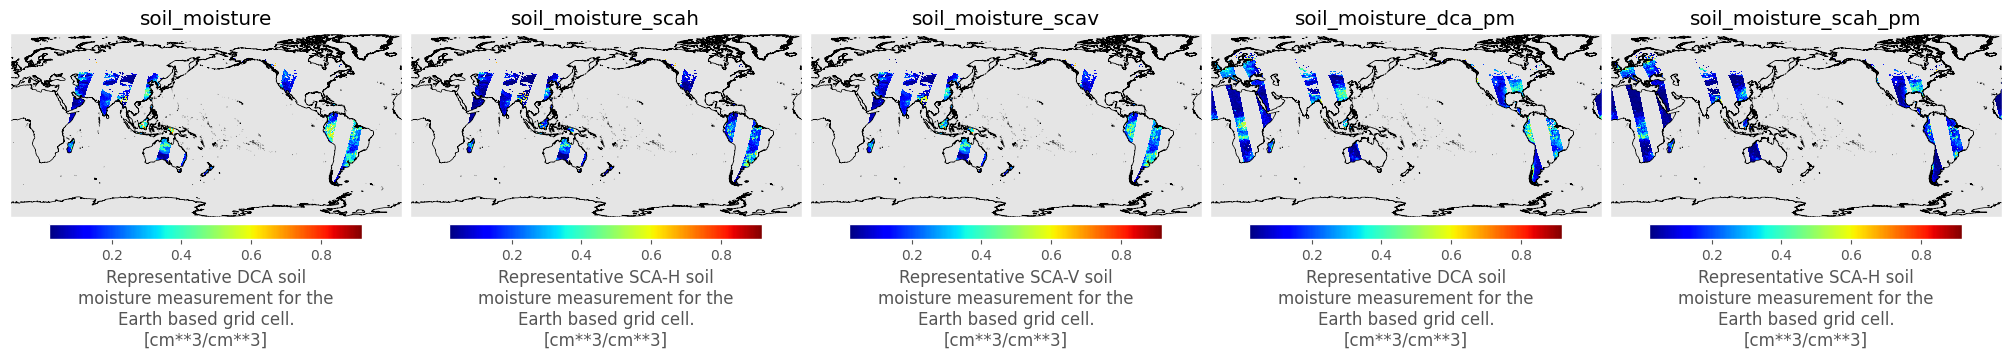

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import colormaps as cmaps
plt.style.use('ggplot')

subplot_kwargs = dict(transform =  ccrs.PlateCarree() , cmap = 'jet', cbar_kwargs = dict(shrink = 0.8, pad = 0.001, orientation = 'horizontal'))

fig, ax = plt.subplots(1,5, figsize = (20,50), subplot_kw = {'projection': ccrs.PlateCarree(central_longitude=171)}, layout='constrained')
data_var_list = ['soil_moisture', 'soil_moisture_scah','soil_moisture_scav','soil_moisture_dca_pm','soil_moisture_scah_pm' ]

for i, x in enumerate(ax):
    variable = data_var_list[i]
    ds[variable].plot(ax = x, **subplot_kwargs)
    x.set_title(variable)
    # x.set_extent([130,185, -10, -55])
    x.coastlines('10m')
plt.show()


SMAP documentation: <br><i>
"soil_moisture (soil_moisture_scah,soil_moisture_scav, soil_moisture_dca)
Daily global composite of the estimated soil
moisture at 9 km grid posting, as returned by
the L2_SM_P_E processing software. The
generic soil_moisture field is internally linked
to the output produced by the baseline
algorithm (DCA currently). "</i><br>
<br>
Okay... so let's extract the daily soil moisture from the am and pm channels. In the h5 file, I can only find `soil_moisture` (which was from the `AM` "group" of the `.h5` file), and `soil_moisture_dca_pm` (which was from the `PM` group of the `.h5` file). So, we take the <b>average of these two channels since they are the same (DCA) <b>, but just done at different times of day, i.e. the acending and descending passes. 

In [ ]:
ds_am  = ds[['soil_moisture']].assign_coords({'update':'am'}).expand_dims('update')
ds_pm  = ds[['soil_moisture_dca_pm']].rename(
    {'soil_moisture_dca_pm':'soil_moisture'}).assign_coords({'update':'pm'}).expand_dims('update')


In [ ]:
ds_daily = xr.concat([ds_am, ds_pm], dim = 'update').mean('update')



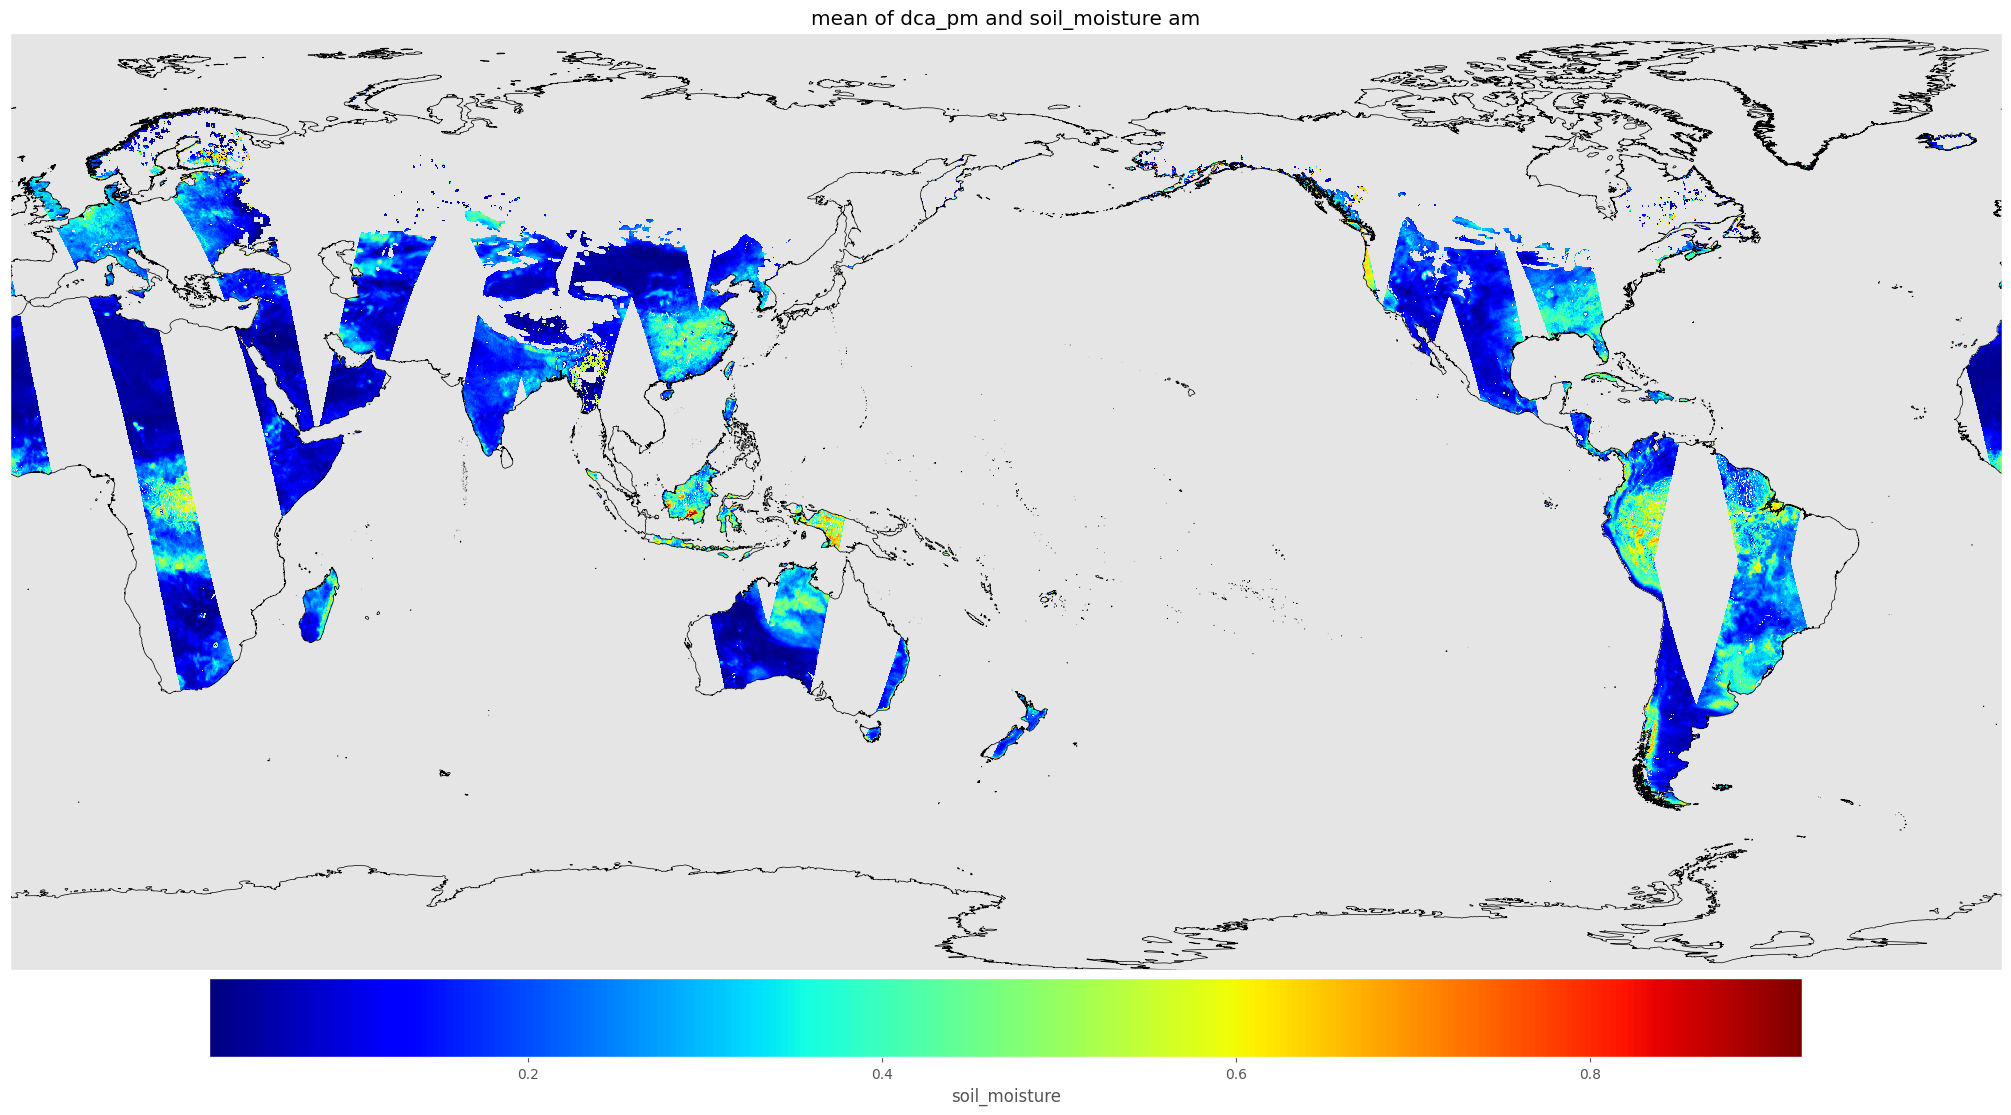

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,50), subplot_kw = {'projection': ccrs.PlateCarree(central_longitude=171)}, layout='constrained')

ds_daily['soil_moisture'].plot(ax = ax, **subplot_kwargs)
ax.set_title('mean of dca_pm and soil_moisture am')
# x.set_extent([130,185, -10, -55])
ax.coastlines('10m')
plt.show()

In [ ]:
dates = pd.date_range('2015-04-01', '2015-04-05')
ease_grid = EASE2_grid(9000)

In [ ]:
%%time
delayed_list = []
for date in dates:
    delayed_list.append(
        delayed(extract_smap)(date, ease_grid, force = True, save = True)
    )

zarrs = compute(deåayed_list)

In [ ]:
import glob

paths = glob.glob('n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/*/*.h5')

zspec = [SingleHdf5ToZarr(str(p)) for p in paths]
# zarr_list = [ZarrToZarr(zarr_path).translate() for zarr_path in paths]

# # zspecs = [SingleHdf5ToZarr(str(p)).translate() for p in paths]
# json = MultiZarrToZarr(zarr_list, concat_dims = 'time', identical_dims = ['lat','lon']).translate()
# # concatenate_arrays(zarr_list)



In [ ]:
import h5py
import re
import glob

regex = re.compile("SMAP_L3_SM_P_E_(\d{8})_R\d{5}_\d{3}\.h5")

paths = glob.glob('n5eil01u.ecs.nsidc.org/SMAP/SPL3SMP_E.006/*/*.h5')

In [ ]:
def extract_h5_data(path : str):
    
    try:
        h5_file.close()
    except:
        pass
    h5_file = h5py.File(path, 'r')

    # json = SingleHdf5ToZarr(path).translate()
    json = SingleHdf5ToZarr(h5_file["Soil_Moisture_Retrieval_Data_AM"], url = path).translate()
    return json

In [ ]:
h5_file = h5py.File(paths[1], 'r')


h5_file["Soil_Moisture_Retrieval_Data_AM"].attrs

In [ ]:
zspec = MultiZarrToZarr(path = paths, indicts=json_list, coo_map={'time': regex}, identical_dims=['phony_dim_0', 'phony_dim_1']).translate()

In [ ]:
xr.open_dataset(zspec, engine = "kerchunk", group = "Soil_Moisture_Retrieval_Data_AM", chunks = {})

In [ ]:
xr.open_dataset(zspec_list[0], engine='kerchunk', chunks = {})

In [ ]:
zspec_list[-1]

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import colormaps as cmaps
plt.style.use('ggplot')

subplot_kwargs = dict(transform =  ccrs.PlateCarree() , cmap = cmaps.lipari_r, cbar_kwargs = dict(shrink = 0.8, pad = 0.001, orientation = 'horizontal'))

fig, ax = plt.subplots(1,2, figsize = (10,5), subplot_kw = {'projection': ccrs.PlateCarree()}, layout='constrained')

ds['soil_moisture'].plot(ax = ax[0], **subplot_kwargs)
ds_adjusted['soil_moisture'].plot(ax = ax[1],  **subplot_kwargs)

for x in ax:
    x.set_extent([160,180, -38, -60])
    x.coastlines('10m')
    
ax[0].set_title('Cropping EASE Grid')
ax[1].set_title('Creating linspace from EASE Grid')
plt.show()